In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import time
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import os
import plotly.express as px
import plotly
import seaborn as sns
import csv

filePath = "../data/mbti_1.csv"

df = pd.read_csv(filePath,header=0)
df.head(10)

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...
5,INTJ,'18/37 @.@|||Science is not perfect. No scien...
6,INFJ,"'No, I can't draw on my own nails (haha). Thos..."
7,INTJ,'I tend to build up a collection of things on ...
8,INFJ,"I'm not sure, that's a good question. The dist..."
9,INTP,'https://www.youtube.com/watch?v=w8-egj0y8Qs||...


<Figure size 3600x1440 with 0 Axes>

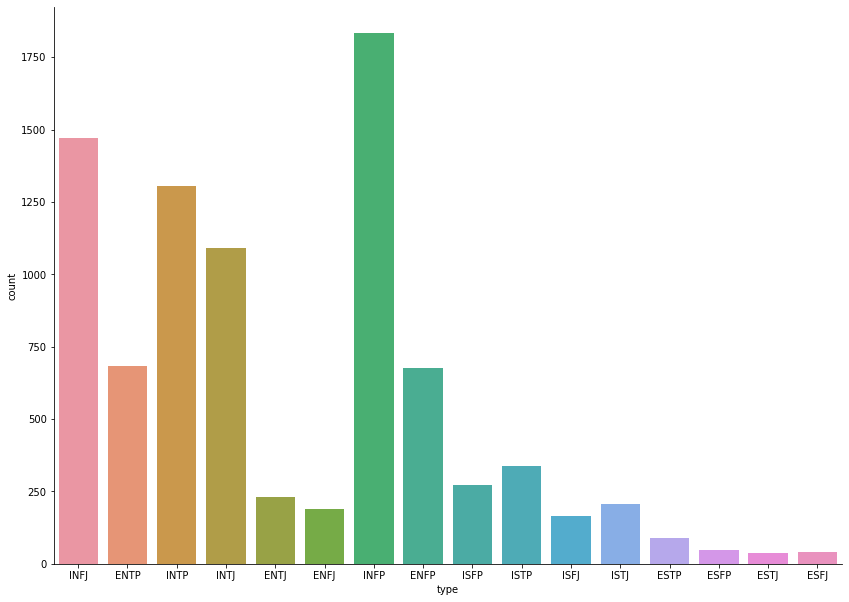

In [34]:
fig = plt.gcf()
fig.set_size_inches(50, 20)
sns.catplot(x="type", kind="count", data=df,height=8.27, aspect=11.7/8.27)

In [2]:
df["type"] = df["type"].str.strip()
# Seperate the the label into four different parts
target_multi_label = df["type"].str.split(r".",expand=True)
target_multi_label = df["type"].apply(lambda x:pd.Series(list(x)))

target_multi_label.columns = ["Personality-1","Personality-2","Personality-3","Personality-4"]

df = pd.concat([df,target_multi_label] , axis=1)

df.head()

,type,posts,Personality-1,Personality-2,Personality-3,Personality-4
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,I,N,F,J
1,ENTP,'I'm finding the lack of me in these posts ver...,E,N,T,P
2,INTP,'Good one _____ https://www.youtube.com/wat...,I,N,T,P
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",I,N,T,J
4,ENTJ,'You're fired.|||That's another silly misconce...,E,N,T,J


<Figure size 3600x1440 with 0 Axes>

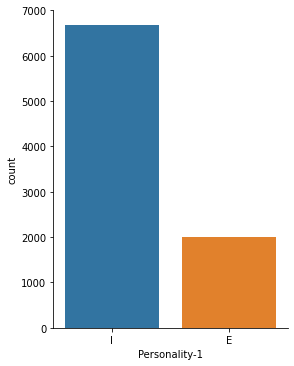

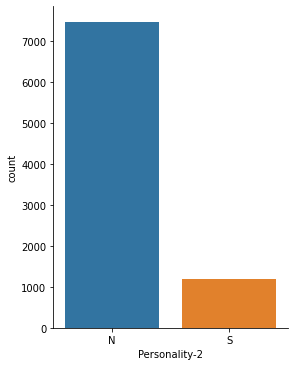

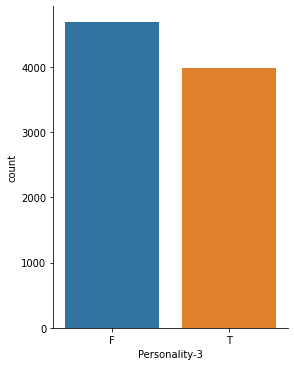

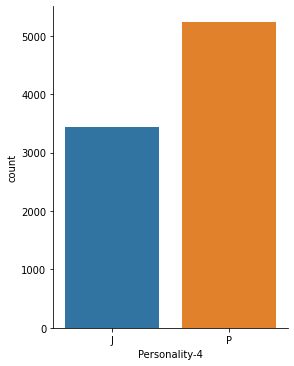

In [ ]:
fig = plt.gcf()
fig.set_size_inches(50, 20)
sns.catplot(x="Personality-1", kind="count", data=df,height=5, aspect=4/5)
sns.catplot(x="Personality-2", kind="count", data=df,height=5, aspect=4/5)
sns.catplot(x="Personality-3", kind="count", data=df,height=5, aspect=4/5)
sns.catplot(x="Personality-4", kind="count", data=df,height=5, aspect=4/5)

In [4]:
#version1 of text pre-processing

#source:https://towardsdatascience.com/nlp-text-preprocessing-a-practical-guide-and-template-d80874676e79
!pip install Unidecode
!pip install contractions
import nltk
nltk.download('wordnet')

from bs4 import BeautifulSoup
import unidecode 
#from word2number import w2n
import contractions
from nltk.stem import WordNetLemmatizer 
import re

def preprocessing_v1(text):
    #remove html information
    soup = BeautifulSoup(text, "html.parser")
    processed = soup.get_text(separator=" ")
    
    #remove http// 
    processed = re.sub(r"http\S+", "", processed)

    #remove ||| seperate
    processed = re.sub(r'\|\|\|', r' ', processed)

    #lower case
    processed = processed.lower()

    #expand shortened words, e.g. don't to do not
    processed = contractions.fix(processed)

    #remove accented char
    processed = unidecode.unidecode(processed)

    #remove white space
    #processed = processed.strip()
    #processed = " ".join(processed.split())

    # Lemmatizing 
    lemmatizer = WordNetLemmatizer() 
    processed=lemmatizer.lemmatize(processed)


    return processed

[nltk_data] Downloading package wordnet to /home/ivan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
df['posts'] = df['posts'].apply(preprocessing_v1)
posts = df['posts']
df.head()

NameError: name 'preprocessing_v1' is not defined

In [7]:
# Labels for introversion vs extraversion
first_dimension = df['Personality-1']
# The model can't predict a float from a char, so we replace the I with 0 and E with 1
# I couldn't do this in place for some reason so i made a new array. This runtime is pretty shit cuz of append

# Make this np.zeros_lke first dim to fix runtime (?)
first_dim = []

for idx, letter in enumerate(first_dimension):
    if letter is 'I':
        first_dim.append(0)
    else:
        first_dim.append(1)

first_dim = np.array(first_dim)
print(first_dim)

[0 1 0 ... 0 0 0]


In [24]:
def convertLabels(labelDf):
    '''
    this will turn the string labels to floats
    '''
    personality_dict = {"ENTJ" : 0, "INTJ" : 1, "ENTP" : 2, "INTP" : 3, "INFJ" : 4, "INFP" : 5, "ENFJ" : 6 , 
                    "ENFP" : 7, "ESTP" : 8, "ESTJ" : 9, "ISTP" : 10, "ISTJ" : 11, "ISFJ" : 12, "ISFP" : 13, 
                    "ESFJ" : 14, "ESFP" : 15}
    type_labels = []
    # Go through the array and turn the personality type into its corresponding number
    for idx, personality in enumerate(labelDf):
        type_labels.append(personality_dict[personality])

    return np.array(type_labels)
full_type_labels = df['type']
# Enumerating the personality types so that our model can work with numbers


type_labels = convertLabels(full_type_labels)

print(type_labels)
# print(full_type_labels)

    

[4 2 3 ... 3 5 5]


In [3]:
'''
This will load the csv
'''
class CsvToDf:
    '''
    This class will simply turn the given data to a dataframe
    '''
    def __init__(self,filename,batchSize=None,cols=None):
        #batchSize is the size of data to be read incrementally. This is for data that is to big to fit
        #into memory
        self._cols = cols
        self._header = None
        self._filename = filename
        self._curIndex = 0     #this will be the current index that we are in the csv
        self._isRead = False
        self._df = None
        self._storeHeader()
        self._batchSize = batchSize
    def _storeHeader(self):
        with open(self._filename) as csvFile:
            f = csv.reader(csvFile)
            self._header = next(f)
    def getWholeCsv(self):
        if not(self._isRead):
            if self._cols != None:
                self._df = pd.read_csv(self._filename,usecols=self._cols)
            else:
                self._df = pd.read_csv(self._filename)
            self._isRead = True
        return self._df
    def getHeader(self):
        return self._header
    def _checkIfRead(self):
        if not(self._isRead):
            if self._cols != None:
                self._df = pd.read_csv(self._filename,iterator=True,chunksize=self._batchSize,usecols=self._cols)
            else:
                self._df = pd.read_csv(self._filename,iterator=True,chunksize=self._batchSize)
            self._isRead = True
            return False
        return True
    def getNextBatchCsv(self):
        self._checkIfRead()
        return next(self._df,None)

In [44]:
#================ counting the smallest number of data
TEST = "test"
TRAIN = "train"
class Combiner:
    '''
    - Given multiple CsvToDf that correspond to a dataset combine them to a single dataframe
    - return this dataframe
    - need to return a dataframe that only has type and post as its columns
    '''
    def __init__(self,dataList,columnList):
        '''
        dataList is the CsvToDf that contains all the data and columnList is a list that contains the necessary
        column names for a corresponding entry in dataList.
        '''
        assert len(dataList) == len(columnList),"incorrect sizes for data"
        self._dataList = dataList
        self._data = [None for i in range(len(dataList))]
        self._necessaryCol = columnList
        self._typeCol = "type"
        self._postCol = "posts"
        self._incrementData()
    def getNextBatch(self):
        '''
        return a dataframe that contains all the aggregated data
        '''
        outData = pd.DataFrame(columns=[self._typeCol,self._postCol])
        for data,colList in zip(self._data,self._necessaryCol):
            if isinstance(data,pd.DataFrame):
                renamedData = data[[colList[0],colList[1]]]
                renamedData.columns = [self._typeCol,self._postCol]
                
                outData = outData.append(renamedData,ignore_index=True)
        self._incrementData()
        if (len(outData.index)) == 0:
            return None
        else:
            return outData
    def _incrementData(self):
        for idx,i in enumerate(self._dataList):
            self._data[idx] = i.getNextBatchCsv()
class Balancer:
    '''
    - Balance the count
    - Decide what the training and test dat will be
    - Needs to output three data frames the train the test and the remainder
    - make the remainder the training set
    '''
    def __init__(self,combiner,trainFreq,testFreq):
        #personSize is minimum size of the number of people in a single personality group
        self._combiner = combiner
        self._typeCol = "type"
        self._postCol = "posts"
        self._personality_count = {"ENTJ" : {TRAIN:0,TEST:0}, "INTJ" : {TRAIN:0,TEST:0}, "ENTP" : {TRAIN:0,TEST:0}, "INTP" : {TRAIN:0,TEST:0}, "INFJ" : {TRAIN:0,TEST:0}, "INFP" : {TRAIN:0,TEST:0}, "ENFJ" : {TRAIN:0,TEST:0} , 
                    "ENFP" : {TRAIN:0,TEST:0}, "ESTP" : {TRAIN:0,TEST:0}, "ESTJ" : {TRAIN:0,TEST:0}, "ISTP" : {TRAIN:0,TEST:0}, "ISTJ" : {TRAIN:0,TEST:0}, "ISFJ" : {TRAIN:0,TEST:0}, "ISFP" : {TRAIN:0,TEST:0}, 
                    "ESFJ" : {TRAIN:0,TEST:0}, "ESFP" : {TRAIN:0,TEST:0}}
        self._trainFreq = trainFreq
        self._testFreq = testFreq
        self._training = []
        self._testing = []
    def createDataSets(self):
        self._training = []
        self._testing = []
        batch = self._combiner.getNextBatch()
        while (not(self._isUniform(freq)) or len(self._testing) < minTest) and isinstance(batch,pd.DataFrame):
            for idx,row in batch.iterrows():
                if isinstance(row[self._typeCol],str):
                    personality = row[self._typeCol].upper()
                    if personality in self._personality_count:
                        if self._personality_count[personality] < freq:
                            self._training.append({self._typeCol:personality,self._postCol:row[self._postCol]})
                            self._personality_count[personality] += 1
                        elif len(self._testing) < maxTest:
                            self._testing.append({self._typeCol:personality,self._postCol:row[self._postCol]})
            batch = self._combiner.getNextBatch()
        return True
    def getTrainSet(self):
        return pd.DataFrame(self._training)
    def getTestSet(self):
        return pd.DataFrame(self._testing)
    def _trainIsUniform(self):
        #checks if personality count has equal distribution
        for key in self._personality_count:
            if self._personality_count[key] < freq:
                return False
        return True
    def _testIsUniform(self):
        #checks if personality count has equal distribution
        for key in self._personality_count:
            if self._personality_count[key] < freq:
                return False
        return True
#======================================================

In [45]:
file1 = CsvToDf("../data/mbti_1.csv",batchSize=400)
file2 = CsvToDf("../data/mbti9k_comments.csv",batchSize=100) 
file3 = CsvToDf("../data/typed_posts.csv",batchSize=100)
file4 = CsvToDf("../data/typed_comments.csv",batchSize=100)

combine = Combiner([file1,file2,file3,file4],[["type","posts"],["type","comment"],["type","title"],["type","comment"]])
balancer = Balancer(combine)
balancer.createDataSets(100,600,1000)




True

In [14]:
res = balancer.getTrainSet()
personality_dict = {"ENTJ" : 0, "INTJ" : 0, "ENTP" : 0, "INTP" : 0, "INFJ" : 0, "INFP" : 0, "ENFJ" : 0, 
                    "ENFP" : 0, "ESTP" : 0, "ESTJ" : 0, "ISTP" : 0, "ISTJ" : 0, "ISFJ" : 0, "ISFP" : 0, 
                    "ESFJ" : 0, "ESFP" : 0}
for idx,row in res.iterrows():
    personality_dict[row["type"]] += 1
print(personality_dict)

{'ENTJ': 100, 'INTJ': 100, 'ENTP': 100, 'INTP': 100, 'INFJ': 100, 'INFP': 100, 'ENFJ': 100, 'ENFP': 100, 'ESTP': 100, 'ESTJ': 100, 'ISTP': 100, 'ISTJ': 100, 'ISFJ': 100, 'ISFP': 100, 'ESFJ': 100, 'ESFP': 100}


In [ ]:
def counter(ctd):
    personality_dict = {"ENTJ" : 0, "INTJ" : 0, "ENTP" : 0, "INTP" : 0, "INFJ" : 0, "INFP" : 0, "ENFJ" : 0, 
                    "ENFP" : 0, "ESTP" : 0, "ESTJ" : 0, "ISTP" : 0, "ISTJ" : 0, "ISFJ" : 0, "ISFP" : 0, 
                    "ESFJ" : 0, "ESFP" : 0}
    curCtd = ctd.getNextBatchCsv()
    while isinstance(curCtd,pd.DataFrame):
        for idx,row in curCtd.iterrows():
            if isinstance(row["type"],str):
                personality = row["type"].upper()
                if personality in personality_dict:
                    personality_dict[personality] += 1
        curCtd = ctd.getNextBatchCsv()
    return personality_dict
print(counter(file1))
print(counter(file2))
print(counter(file3))
print(counter(file4))

{'ENTJ': 231, 'INTJ': 1091, 'ENTP': 685, 'INTP': 1304, 'INFJ': 1470, 'INFP': 1832, 'ENFJ': 190, 'ENFP': 675, 'ESTP': 89, 'ESTJ': 39, 'ISTP': 337, 'ISTJ': 205, 'ISFJ': 166, 'ISFP': 271, 'ESFJ': 42, 'ESFP': 48}
{'ENTJ': 358, 'INTJ': 1837, 'ENTP': 624, 'INTP': 2313, 'INFJ': 1023, 'INFP': 1070, 'ENFJ': 206, 'ENFP': 605, 'ESTP': 88, 'ESTJ': 53, 'ISTP': 445, 'ISTJ': 236, 'ISFJ': 134, 'ISFP': 161, 'ESFJ': 34, 'ESFP': 65}
{'ENTJ': 13886, 'INTJ': 79680, 'ENTP': 29330, 'INTP': 102763, 'INFJ': 31243, 'INFP': 43876, 'ENFJ': 4460, 'ENFP': 22744, 'ESTP': 3808, 'ESTJ': 1354, 'ISTP': 11679, 'ISTJ': 11470, 'ISFJ': 4036, 'ISFP': 3773, 'ESFJ': 400, 'ESFP': 1583}


In [ ]:
def counterDf(df):
    personality_dict = {"ENTJ" : 0, "INTJ" : 0, "ENTP" : 0, "INTP" : 0, "INFJ" : 0, "INFP" : 0, "ENFJ" : 0, 
                    "ENFP" : 0, "ESTP" : 0, "ESTJ" : 0, "ISTP" : 0, "ISTJ" : 0, "ISFJ" : 0, "ISFP" : 0, 
                    "ESFJ" : 0, "ESFP" : 0}

    for idx,row in df.iterrows():
        if isinstance(row["type"],str):
            personality = row["type"].upper()
            if personality in personality_dict:
                personality_dict[personality] += 1
    return personality_dict
counterDf(balancer.getTrainSet())

In [46]:
training_posts = balancer.getTrainSet()["posts"]
training_labels = convertLabels(balancer.getTrainSet()["type"])
testing_posts = balancer.getTestSet()["posts"]
testing_labels = convertLabels(balancer.getTestSet()["type"])
print(testing_labels)

[5 5 5 5 5 5 5 5 5 1 1 1 1 1 1 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 5 3 5 5 3 5 5 3 2 3 1 5 5 5 5 3 5 2 1 3 1 2 5 5 3
 5 1 2 3 1 1 1 1 5 5 2 5 5 5 1 3 1 3 5 3 5 3 3 5 2 1 1 2 1 5 3 5 3 1 1 1 3
 1 1 5 5 3 3 3 5 2 5 5 5 5 1 3 5 2 2 1 5 5 1 1 3 1 5 2 5 3 5 4 4 2 4 3 1 5
 5 4 4 1 3 2 2 1 5 5 5 4 5 5 1 4 5 3 5 1 5 4 5 3 3 5 4 2 3 5 4 1 4 4 5 5 4
 3 5 1 2 2 5 1 5 1 1 2 5 5 3 4 3 5 4 1 2 4 3 3 4 5 3 2 5 5 3 3 5 5 2 5 4 2
 5 5 1 5 4 5 4 4 5 1 2 2 5 3 5 5 2 4 1 2 3 5 5 4 1 1 5 4 4 1 1 3 4 4 5 4 1
 3 4 5 1 1 3 3 4 3 2 1 5 5 4 3 3 4 5 3 4 1 4 4 4 5 4 4 3 5 5 5 3 5 2 5 1 3
 1 5 5 3 4 3 1 4 2 5 1 5 1 3 2 1 4 3 3 3 4 1 3 3 3 3 3 1 2 5 2 5 2 2 5 4 1
 3 1 4 1 5 1 3 3 2 4 1 5 3 1 1 5 3 1 5 1 1 3 3 3 1 1 1 1 1 3 1 1 3 3 4 1 1
 3 3 1 1 5 3 4 3 5 1 1 5 3 2 1 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 

In [47]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

print(len(testing_posts.index))
# Only considering the top 10000 most common words
vocab_size = 10000
max_length = 2016
# We have 8675 rows
#training_size = 8675//2
#training_posts = posts[0:training_size]
#testing_posts = posts[training_size:]

# Right now is only predicting introversion or extroversion
#training_labels = type_labels[0:training_size]
#testing_labels = type_labels[training_size:]

# We only want to fit the tokenizer on the training, not the testing
tokenizer = Tokenizer(num_words = vocab_size, oov_token = "<OOV>")
tokenizer.fit_on_texts(training_posts)

word_index = tokenizer.word_index

# Puts the padding (which are 0) at the end of the vectorized sentence.
# The longest post in our dataset is 2016, but we should truncate='post' earlier than 2016 words
training_sequences = tokenizer.texts_to_sequences(training_posts)
training_padded = pad_sequences(training_sequences, padding = 'post', maxlen = max_length)
# training_sequences = np.array(training_sequences)
training_padded = np.array(training_padded)


testing_sequences = tokenizer.texts_to_sequences(testing_posts)
print(len(testing_sequences))
testing_padded = pad_sequences(testing_sequences, padding = 'post', maxlen=max_length)
# testing_sequences = np.array(testing_sequences)
testing_padded = np.array(testing_padded)



1000
1000


In [27]:
# # Commenting out for similar reasons

# #Second parameter is the output dimension. Therefore, when we are changing this to predict 4 dimensions of personality we should change it to 4
# embedding_dim = 1

# model = tf.keras.Sequential([ 
#                              tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
#                              tf.keras.layers.GlobalAveragePooling1D(),
#                              tf.keras.layers.Dense(24, activation='relu'),
#                              tf.keras.layers.Dense(1, activation='sigmoid')
# ])

# model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [49]:
#Second parameter is the output dimension. Therefore, when we are changing this to predict 4 dimensions of personality we should change it to 4
# ^^ actually i dont know if that is true
embedding_dim = 256
'''
Embedding layer will always have vocab_size*embedding_dim parameters. Since vocab_size is 10,000 the number of parameters on this layer will always be large
'''
model = tf.keras.Sequential([ 
                             tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
                            tf.keras.layers.GRU(256),
                            tf.keras.layers.SimpleRNN(256),
                             #tf.keras.layers.GlobalAveragePooling1D(),
                            #tf.keras.layers.Dense(1000, activation='relu'),
                            # tf.keras.layers.Dense(400, activation='relu'),
                                #tf.keras.layers.Dense(64, activation='relu'),
                             #tf.keras.layers.Dense(32, activation='relu'),
                             tf.keras.layers.Dense(16, activation='softmax')
])

model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [50]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 2016, 256)         2560000   
_________________________________________________________________
gru_1 (GRU)                  (None, 2016, 256)         393984    
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 256)               131328    
_________________________________________________________________
dense_12 (Dense)             (None, 16)                4112      
Total params: 3,089,424
Trainable params: 3,089,424
Non-trainable params: 0
_________________________________________________________________


In [ ]:
num_epochs = 10
print(len(testing_padded))
print(len(testing_labels))
history = model.fit(training_padded, training_labels, epochs = num_epochs, validation_data=(testing_padded, testing_labels), verbose = 1)

1000
1000
Train on 1600 samples, validate on 1000 samples
Epoch 1/10
1600/1600 [==============================] - 255s 160ms/sample - loss: 2.8374 - acc: 0.0694 - val_loss: 2.6456 - val_acc: 0.0930
Epoch 2/10
1600/1600 [==============================] - 293s 183ms/sample - loss: 2.7905 - acc: 0.0775 - val_loss: 2.9270 - val_acc: 0.0000e+00
Epoch 3/10
1600/1600 [==============================] - 286s 179ms/sample - loss: 2.7761 - acc: 0.0850 - val_loss: 2.8973 - val_acc: 0.0930
Epoch 4/10
1568/1600 [============================>.] - ETA: 5s - loss: 2.7555 - acc: 0.0982 